In [9]:
import pandas as pd
from datetime import datetime, timedelta
import cartopy.crs as crs
import cartopy.feature as feat
import matplotlib.pyplot as plt
import numpy as np


In [10]:
latMin = np.mod(36, 360)
latMax = np.mod(48, 360)
lonMin = 46
lonMax = 55
def windowToAxes(window):
    return [window[0]['lon'], window[1]['lon'], window[1]['lat'], window[0]['lat']]

window = [{'lat': latMax, 'lon': lonMax}, {'lat': latMin, 'lon': lonMin}]

In [11]:
# 2021 path has a different CF convention. therefore also changed surface type flag
data2016Path = "./reduced_caspian_2016.csv"


data2018Path = "./reduced_caspian_2018.csv"

data2021Path = "./reduced_caspian_2021.csv"
surface_type_flag = 1


df2016 = pd.read_csv(data2016Path)

df2018 = pd.read_csv(data2018Path)
df2021 = pd.read_csv(data2021Path)

## Plot a sample

[167. 208. 234. 243.  15.  30.  56.  91. 106. 132.  29. 105.]


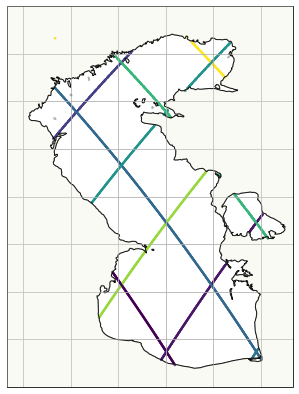

In [8]:
df = df2016

data = df.loc[(df.month == 7) & (df["surface type"] == surface_type_flag)]


fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent(windowToAxes(window))
ax.add_feature(feat.LAND, zorder=100, edgecolor='k', alpha=0.3)
ax.coastlines()
ax.scatter(x=data["lon"], y=data["lat"], c=data["pass number"], s=2, transform=crs.PlateCarree(central_longitude=0))
ax.gridlines(draw_labels=False)

print(data["pass number"].unique())

# Find intersecting points

In [75]:
days = [x for x in range(1, 32)]
months = [1,2,3,4,5,6,7,8,9,10,11,12]
dataset = []
monthly = []
datasets = [df2016, df2018, df2021]
surfaceTypeFlags = [1, 1, 2] # Flags corresponding to the correct dataset (CF-1.* Notation)

for index, df in enumerate(datasets):
    print("dataset: {}".format(df.year.values[0]))
    for month in months:
        data = df.loc[(df.month == month) & (df["surface type"] == surfaceTypeFlags[index])]
        d = []
        
        if str(df.year.values[0]) == "2016" and month < 7:
            print("Skipping month:", month)
            continue
        
        print("Calculating for month:", month)

        
        # Create a list of pass numbers that has usable intersections
        passNumbersWithIntersections = [(91, 207), (91, 29), (91, 56), (91, 133), (15, 29), (15, 207), (167, 56), (243, 133)]

        # Find an intersection points between pass number
        for intersection in passNumbersWithIntersections:
            p1 = data.loc[(df["pass number"] == intersection[0])]
            p2 = data.loc[(df["pass number"] == intersection[1])]

            if (intersection[1] == 133):
                p2 = data.loc[(df["pass number"] == intersection[1]) | (df["pass number"] == 132)]
            if (intersection[1] == 207):
                p2 = data.loc[(df["pass number"] == intersection[1]) | (df["pass number"] == 208)]
            if (intersection[1] == 56):
                p2 = data.loc[(df["pass number"] == intersection[1]) | (df["pass number"] == 55)]

            v1 = np.column_stack(([p1["lat"].values, p1["lon"].values]))
            v2 = np.column_stack(([p2["lat"].values, p2["lon"].values]))

            distances = []
            indices = []
            for i, point in enumerate(v1):
                # Calculate distance to point in v2
                for j, point2 in enumerate(v2):
                    dist = np.linalg.norm(point - point2)
                    distances.append(dist)
                    indices.append((i, j))
            try:
                min_value = min(distances)
            except ValueError as e:
                print("Val error: ",e, intersection)
            min_index = distances.index(min_value)

            k = indices[min_index]
            n = 3
            i1 = [x for x in range(k[0]-n, k[0]+n)]
            i2 = [x for x in range(k[1]-n, k[1]+n)]
            d.append(pd.concat([p1.iloc[i1], p2.iloc[i2]]))
        monthly.append(d)
    dataset.append(monthly)
print("Finished")

dataset: 2016
Skipping month: 1
Skipping month: 2
Skipping month: 3
Skipping month: 4
Skipping month: 5
Skipping month: 6
Calculating for month: 7
Calculating for month: 8
Calculating for month: 9
Calculating for month: 10
Calculating for month: 11
Calculating for month: 12
dataset: 2018
Calculating for month: 1
Calculating for month: 2
Calculating for month: 3
Calculating for month: 4
Calculating for month: 5
Calculating for month: 6
Calculating for month: 7
Calculating for month: 8
Calculating for month: 9
Calculating for month: 10
Calculating for month: 11
Calculating for month: 12
dataset: 2021
Calculating for month: 1
Calculating for month: 2
Calculating for month: 3
Calculating for month: 4
Calculating for month: 5
Calculating for month: 6
Calculating for month: 7
Calculating for month: 8
Calculating for month: 9
Calculating for month: 10
Calculating for month: 11
Calculating for month: 12
Finished


# Create a new dataframe which contains only points near the intersections

In [387]:
averagedSSH = []
averagedMSS = []
SSH = np.zeros((0,0))
MSS = np.zeros((0,0))

dataframes = []
for i, m in enumerate(monthly):
    levels = []
    ranges = []
    altitudes = []
    for i, intersection in enumerate(m):
        ranges.append(intersection.range.values)
        altitudes.append(intersection.altitude.values)
        levels.append(intersection.mss.values)
        dataframes.append(intersection)
        
    
    rng = np.array(ranges).flatten()
    alt = np.array(altitudes).flatten()
    rngAlt = np.column_stack([rng, alt])
    rngAlt = np.delete(rngAlt, np.where(rngAlt[:,0] > 1.349699e+07)[0], axis=0)
    diff = (rngAlt[:,1] - rngAlt[:,0] )
    
    mss = np.array(levels).flatten()
    mss = np.delete(mss, np.where(mss > 1.349699e+07)[0], axis=0)

    averagedSSH.append(np.mean(diff))
    averagedMSS.append(np.mean(mss))
    
    SSH = np.append(SSH, np.array(diff).flatten())
    MSS = np.append(MSS, mss)



# Create a dataframe which separates intersections

In [386]:
intersectionListMean = []
for i, m in enumerate(monthly):
    intersectionMeans = []
    
    for i, intersection in enumerate(m):
        sshList = []
        for x in range(len(intersection.range.values)):
            if (intersection.range.values[x] > 1.349699e+07):
                continue
            ssh = intersection.altitude.values[x] - intersection.range.values[x]
            sshList.append(ssh)
            
        intersectionMeans.append(np.mean(np.array(sshList)))
    
    intersectionListMean.append(intersectionMeans)

intersectionListMean = np.array(intersectionListMean)



In [385]:
dfinter = pd.DataFrame(intersectionListMean)
dfinter.columns = ["Intersection 1","Intersection 2", "Intersection 3", "Intersection 4", "Intersection 5", "Intersection 6", "Intersection 7", "Intersection 8", ]

dfinter.fillna(method='ffill', inplace=True)
dfinter["avg"] = dfinter.sum(axis=1, skipna=True) / 8
dfinter["month"] = dfinter.index + 7
dfinter["year"] = 2016

for i, month in enumerate(dfinter["month"]):
    dfinter.loc[dfinter['month'] > 13, "year"] = 2018
    dfinter.loc[dfinter['month'] > 24, "year"] = 2021

dfinter["month"] = dfinter["month"].apply(lambda x: 12 if ((x % 12) == 0) else x % 12)


## Plot averaged SSH

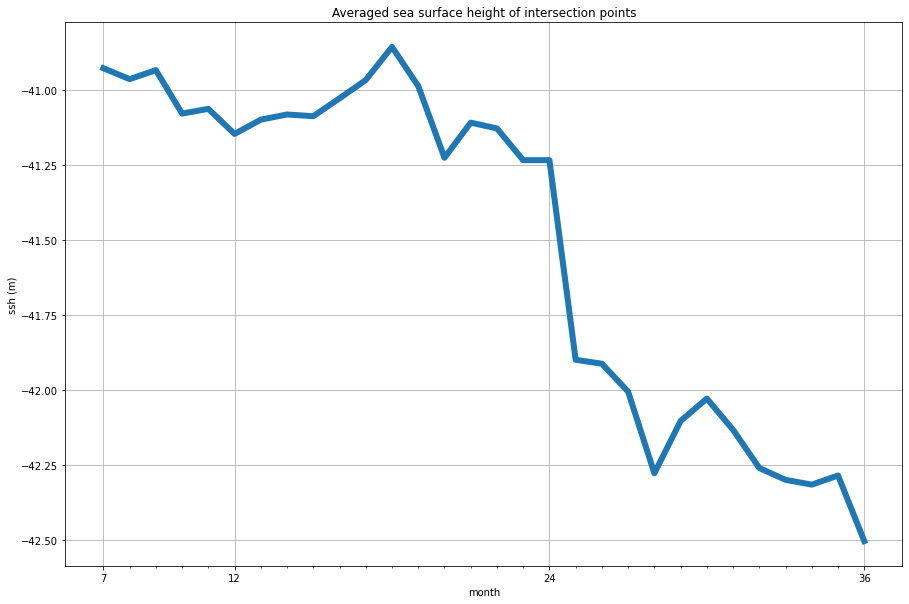

In [388]:
offset = 7
x = [x for x in range(offset, len(monthly) + offset)]

plt.rcParams['figure.figsize'] = [15, 10]

major_ticks = [7, 12, 24, 36]
minor_ticks = np.arange(offset, len(monthly)+offset, 1)


fig, ax = plt.subplots()
ax.plot(dfinter.index + offset, dfinter.avg.values,
       linewidth=6)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.set(xlabel='month', ylabel='ssh (m)',
       title='Averaged sea surface height of intersection points')
ax.grid()

# PLOT SSH For each Intersection

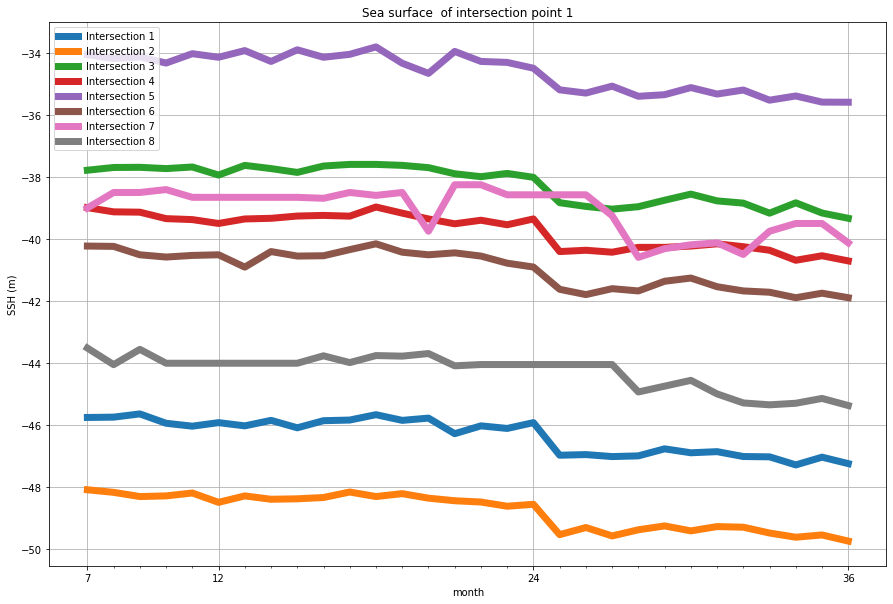

In [389]:
from cycler import cycler

plt.rcParams['figure.figsize'] = [15, 10]

major_ticks = [7, 12, 24, 36]
minor_ticks = np.arange(offset, len(monthly)+offset, 1)

fig, ax = plt.subplots()
offset = 7

for i in range(len(intersectionListMean[0])):
    ax.plot(dfinter.index + offset, dfinter.iloc[:,i]
            ,linewidth=7
            ,label=str(dfinter.columns[i]))
    

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.set(xlabel='month', ylabel='SSH (m)',
       title='Sea surface  of intersection point 1')
plt.legend(loc="upper left")

ax.grid()

# Average all intersections and plot mss for whole Caspian

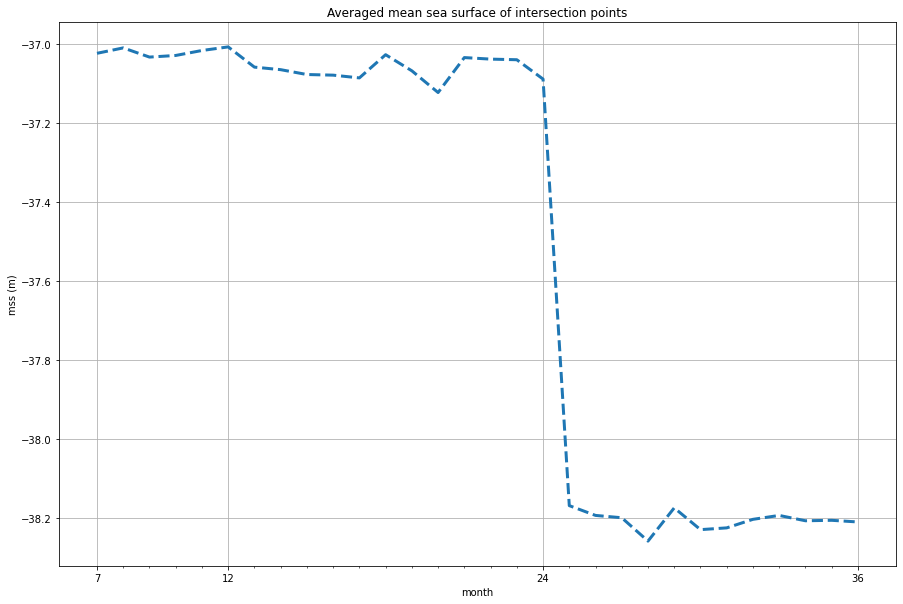

In [390]:
fig, ax = plt.subplots()
ax.plot(x, averagedMSS,
       linestyle='dashed',
       linewidth=3)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.set(xlabel='month', ylabel='mss (m)',
       title='Averaged mean sea surface of intersection points')
ax.grid()


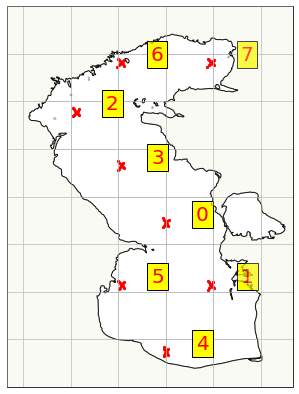

In [183]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent(windowToAxes(window))
ax.add_feature(feat.LAND, zorder=100, edgecolor='k', alpha=0.3)
ax.coastlines()

for i, serie in enumerate(d):
    ax.scatter(x=serie["lon"], y=serie["lat"], c="red", s=5,  transform=crs.PlateCarree(central_longitude=0))
    plt.text(x=serie["lon"].iloc[1] + 1,
             y=serie["lat"].iloc[1]
             ,s=str(i), 
          fontdict=dict(color="red",size=20),
          bbox=dict(facecolor="yellow",alpha=1))


ax.gridlines(draw_labels=False)

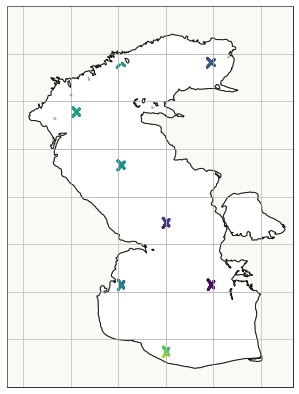

In [185]:
dfRangeFiltered = df.loc[(df["range"] < 1.349699e+07)]
rngAlt = np.column_stack([dfRangeFiltered["range"].values, dfRangeFiltered["altitude"].values])
diff = (rngAlt[:,1] - rngAlt[:,0] )

fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent(windowToAxes(window))
ax.add_feature(feat.LAND, zorder=100, edgecolor='k', alpha=0.3)
ax.coastlines()
ax.scatter(x=dfRangeFiltered["lon"], y=dfRangeFiltered["lat"], c=diff, s=2, transform=crs.PlateCarree(central_longitude=0))
ax.gridlines(draw_labels=False)


In [191]:
# Create a collected dataframe from all datasets
df = pd.concat(dataframes)

# But drop rows where range is not providing usefull values
df = df.drop(df[df.range >  1.349699e+07].index)

sum_column = df["altitude"] - df["range"] 
df["ssh"] = sum_column

df.head()



,lat,lon,time,mss,surface type,range,altitude,geophysical quality flag,pass number,day,month,year,ssh
25687,41.318970,50.910027,521321856.0,-41.764000,1.0,1347102.625,1347057.375,127.0,91.0,8,7,2016,-45.250
25688,41.273151,50.944695,521321856.0,-41.878601,1.0,1347088.375,1347043.000,127.0,91.0,8,7,2016,-45.375
25689,41.227322,50.979305,521321856.0,-41.988800,1.0,1347074.125,1347028.625,127.0,91.0,8,7,2016,-45.500
25690,41.181477,51.013866,521321856.0,-42.093800,1.0,1347059.875,1347014.250,127.0,91.0,8,7,2016,-45.625
25691,41.135620,51.048370,521321856.0,-42.200100,1.0,1347045.625,1346999.875,127.0,91.0,8,7,2016,-45.750


## Features and Labels

In [192]:
# Labels are the values we want to predict
labels = np.array(df['mss'])

# Remove the labels from the features
# axis 1 refers to the columns
features= df.drop('ssh', axis = 1)
# Drop unused columns as well
features = features.drop(['surface type', "pass number", "geophysical quality flag", "time"], axis= 1)

# Saving feature names for later use
feature_list = list(features.columns)
print(feature_list)
# Convert to numpy array
features = np.array(features)

['lat', 'lon', 'mss', 'range', 'altitude', 'day', 'month', 'year']


### Attempt 2: Using only meaned SSH for each intersection

In [325]:
# Labels are the values we want to predict
labels = np.array(dfinter['avg'])

# Remove the labels from the features
# axis 1 refers to the columns
features= dfinter.drop('avg', axis = 1)
# Drop unused columns as well
features = features.drop(["Intersection 1","Intersection 2", "Intersection 3", "Intersection 4", "Intersection 5", "Intersection 6", "Intersection 7", "Intersection 8", ]
, axis= 1)

# Saving feature names for later use
feature_list = list(features.columns)
print(feature_list)
# Convert to numpy array
features = np.array(features)

['month', 'year']


## Training and test sets

In [333]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.4)

In [334]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (18, 2)
Training Labels Shape: (18,)
Testing Features Shape: (12, 2)
Testing Labels Shape: (12,)


(12, 2)


## Training the Forest

In [328]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels);

# Predictions

In [329]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'meters.')

Mean Absolute Error: 0.06 meters.


6

# Visualize a single tree

In [252]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png'); 

![Decision Tree](tree.png)

In [254]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 7


# Plotting the results

In [368]:
monthList = [x for x in range(1, 13)]
years = [2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]

yearCol = []
monthCol = []
for year in years:
    for month in monthList:
        monthCol.append(month)
        yearCol.append(year)


res = np.column_stack([monthCol, yearCol])


future_pred = rf.predict(res)



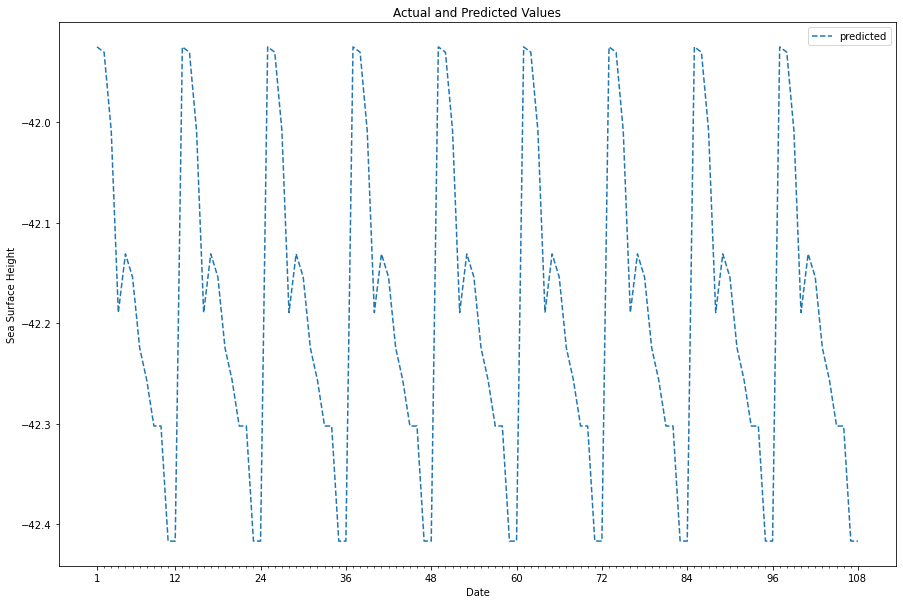

In [378]:
# Plot the actual values
x = [x for x in range(1,  len(future_pred) + 1)]

major_ticks = [1, 12, 24, 36, 48, 60, 72, 84, 96, 108]
minor_ticks = np.arange(1, len(future_pred), 1)

fig, ax = plt.subplots()
offset = 7

ax.plot(x, future_pred, '--', label = 'predicted')

    

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Sea Surface Height'); plt.title('Actual and Predicted Values');

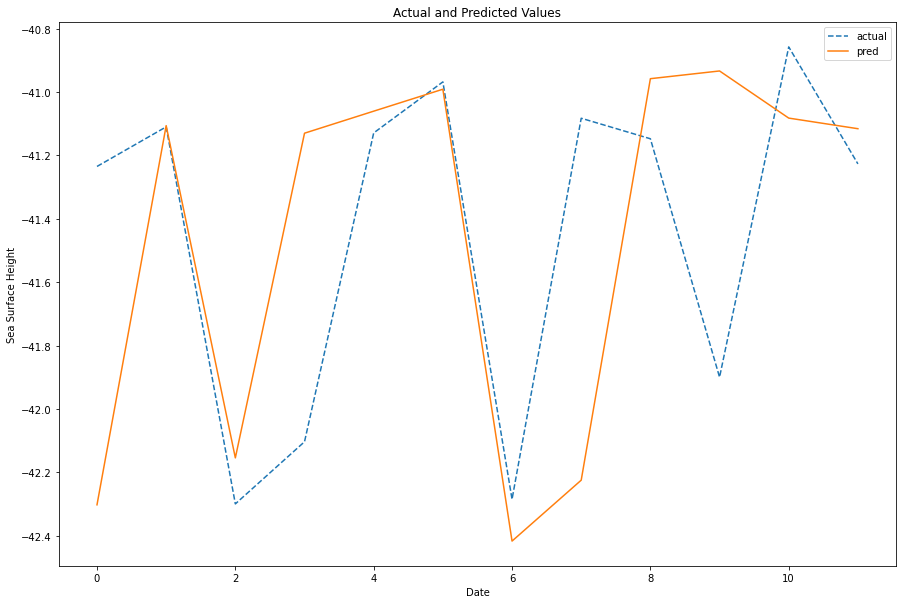

In [379]:
# Plot the actual values
x = [x for x in range(0,  len(predictions))]

plt.plot(x, test_labels, '--', label = 'actual')

plt.plot(x, predictions, '-', label = 'pred')

# Plot the predicted values
#plt.plot(x, predictions_data['prediction'], 'ro', label = 'prediction')
#plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Sea Surface Height'); plt.title('Actual and Predicted Values');
